[구글 코랩(Colab)에서 실행하기](https://colab.research.google.com/github/lovedlim/tensorflow/blob/main/Part%204/4.4_cats_and_dogs_data_processing.ipynb)

## Import

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pylab as plt

## Dataset

In [ ]:
# 구글 드라이브 폴더 마운트 (코랩을 사용하는 경우)
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 압축 파일의 위치 (구글 드라이브 - 내 드라이브 위치)
drive_path = "/content/drive/MyDrive/" 
source_filename = drive_path + "dataset/cat-and-dog.zip"   

# 저장할 경로 
extract_folder = "dataset/"   # 코랩 환경에 임시 저장 

# 압축 해제 
import shutil
shutil.unpack_archive(source_filename, extract_folder)  

## 케라스 ImageDataGenerator 

In [ ]:
# 훈련 셋, 검증 셋 저장위치 지정
train_dir = extract_folder + "archive/training_set/training_set"
valid_dir = extract_folder + "archive/test_set/test_set"
print(train_dir)
print(valid_dir)

dataset/archive/training_set/training_set
dataset/archive/test_set/test_set


In [ ]:
# 이미지 데이터 제너레이터 정의 (Augmentation 미적용)
image_gen = ImageDataGenerator(rescale=(1/255.))
image_gen

In [ ]:
# flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리 
train_gen = image_gen.flow_from_directory(train_dir, 
                                          batch_size=32, 
                                          target_size=(224, 224),   
                                          classes=['cats','dogs'], 
                                          class_mode = 'binary',
                                          seed=2020)

valid_gen = image_gen.flow_from_directory(valid_dir,                                          
                                          batch_size=32, 
                                          target_size=(224, 224),   
                                          classes=['cats','dogs'], 
                                          class_mode = 'binary',
                                          seed=2020)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


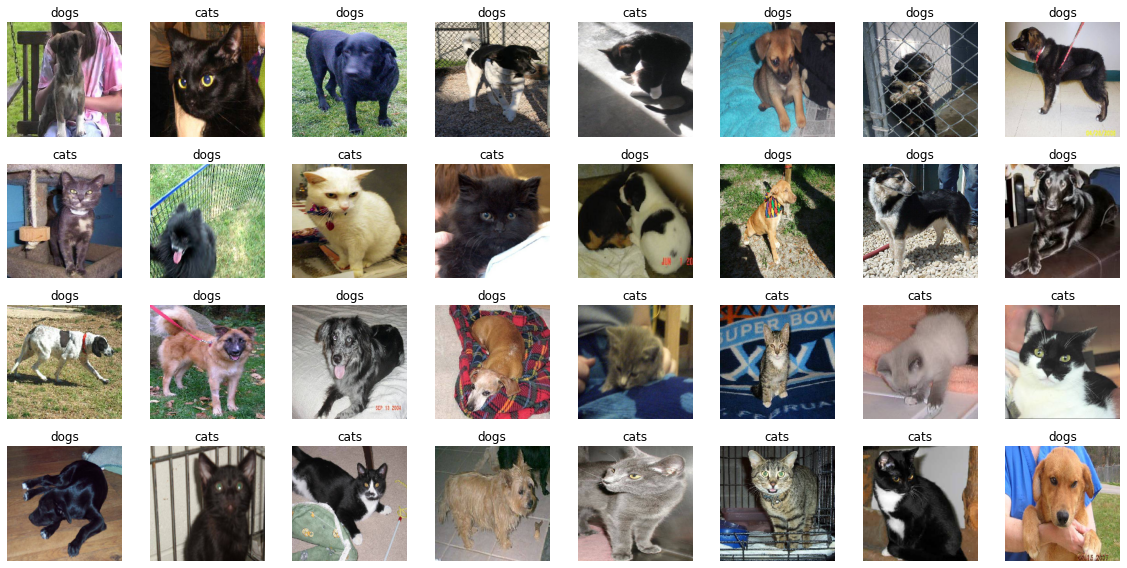

In [ ]:
# 샘플 이미지 출력
class_labels = ['cats', 'dogs']
batch = next(train_gen)
images, labels = batch[0], batch[1]

plt.figure(figsize=(16, 8))
for i in range(32):
    
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(images[i])
    plt.title(class_labels[labels[i].astype(np.int)])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

    model = tf.keras.Sequential([

        # Convolution 층 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    return model

model = build_model()

In [ ]:
# 모델 컴파일
model.compile(optimizer=tf.optimizers.Adam(lr=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_gen, validation_data=valid_gen, epochs=20)

Epoch 1/20
251/251 [==============================] - 35s 137ms/step - loss: 9.1321 - accuracy: 0.5647 - val_loss: 0.6540 - val_accuracy: 0.6006
Epoch 2/20
251/251 [==============================] - 34s 135ms/step - loss: 0.5988 - accuracy: 0.6634 - val_loss: 0.5993 - val_accuracy: 0.6728
Epoch 3/20
251/251 [==============================] - 34s 135ms/step - loss: 0.5857 - accuracy: 0.6873 - val_loss: 0.5855 - val_accuracy: 0.6619
Epoch 4/20
251/251 [==============================] - 34s 135ms/step - loss: 0.5582 - accuracy: 0.7204 - val_loss: 0.5878 - val_accuracy: 0.6915
Epoch 5/20
251/251 [==============================] - 34s 136ms/step - loss: 0.5162 - accuracy: 0.7385 - val_loss: 0.6065 - val_accuracy: 0.6718
Epoch 6/20
251/251 [==============================] - 34s 135ms/step - loss: 0.4993 - accuracy: 0.7352 - val_loss: 0.5569 - val_accuracy: 0.7054
Epoch 7/20
251/251 [==============================] - 34s 135ms/step - loss: 0.4696 - accuracy: 0.7639 - val_loss: 0.5558 - val_ac

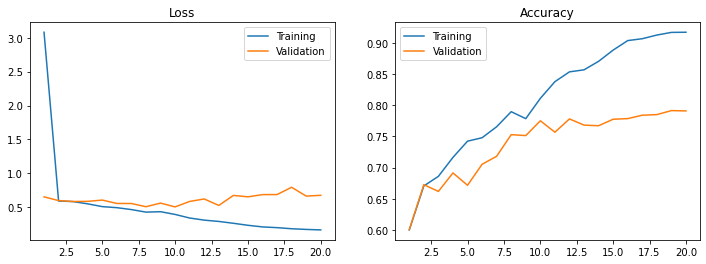

In [ ]:
# 손실함수, 정확도 그래프 그리기 
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 20)

## Data Augmentation

In [ ]:
# 이미지 데이터 제너레이터 정의 (Augmentation 적용)
image_gen_aug = ImageDataGenerator(rescale=1/255., 
                                   horizontal_flip=True,
                                   rotation_range=35,                                
                                   zoom_range=0.2)

# flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리 
train_gen_aug = image_gen_aug.flow_from_directory(train_dir, 
                                                  batch_size=32, 
                                                  target_size=(224,224),   
                                                  classes=['cats','dogs'], 
                                                  class_mode = 'binary', 
                                                  seed=2020)

valid_gen_aug = image_gen_aug.flow_from_directory(valid_dir,  
                                                  batch_size=32, 
                                                  target_size=(224,224),   
                                                  classes=['cats','dogs'], 
                                                  class_mode = 'binary', 
                                                  seed=2020)

# 모델 생성
model_aug = build_model()

# 모델 컴파일
model_aug.compile(optimizer=tf.optimizers.Adam(lr=0.001),  
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# 모델 훈련
history_aug = model_aug.fit(train_gen_aug, validation_data=valid_gen_aug, epochs=40)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Epoch 1/40
251/251 [==============================] - 122s 483ms/step - loss: 7.1604 - accuracy: 0.5467 - val_loss: 0.6631 - val_accuracy: 0.6253
Epoch 2/40
251/251 [==============================] - 121s 482ms/step - loss: 0.6294 - accuracy: 0.6413 - val_loss: 0.6335 - val_accuracy: 0.6792
Epoch 3/40
251/251 [==============================] - 121s 483ms/step - loss: 0.6135 - accuracy: 0.6586 - val_loss: 0.6064 - val_accuracy: 0.6599
Epoch 4/40
251/251 [==============================] - 121s 482ms/step - loss: 0.6060 - accuracy: 0.6558 - val_loss: 0.5441 - val_accuracy: 0.7266
Epoch 5/40
251/251 [==============================] - 121s 483ms/step - loss: 0.5933 - accuracy: 0.6678 - val_loss: 0.5804 - val_accuracy: 0.6950
Epoch 6/40
251/251 [==============================] - 121s 482ms/step - loss: 0.5876 - accuracy: 0.6787 - val_loss: 0.5673 - val_accuracy: 0.7064
Epoch 7/40
251/251 [====================

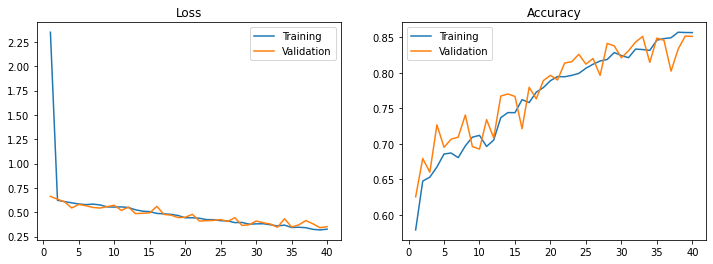

In [ ]:
# 손실함수, 정확도 그래프 그리기 
plot_loss_acc(history_aug, 40)